# Amazon sentiment analysis: Structural correspondence learning

Data downloaded from: processed_acl.tar.gz, processed for John Blitzer, Mark Dredze, Fernando Pereira. Biographies, Bollywood, Boom-boxes and Blenders: Domain Adaptation for Sentiment Classification. Association of Computational Linguistics (ACL), 2007

Method is based on the above paper and the [original SCL paper](http://john.blitzer.com/papers/emnlp06.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from read_funcs import organise_data, vectorise_data, select_high_freq_data
%matplotlib inline
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score

In [2]:
src = 'dvd'
tgt = 'kitchen'
XB, Y_src, XD, Y_tgt = organise_data(src, tgt)

dvd 1000 -1000
kitchen 1000 -1000


In [3]:
# Vectorise the raw data
X_src, X_tgt, features = vectorise_data(XB, XD)
# Reduce the no. of features
N = 10000
X_src, X_tgt, features = select_high_freq_data(X_src, X_tgt, features, N)

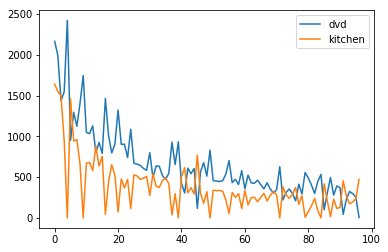

In [4]:
# Visualise the difference in the frequent features
B_count = np.sum(X_src,0)
D_count = np.sum(X_tgt,0)
plt.plot(B_count[-3:-100:-1])
plt.plot(D_count[-3:-100:-1])
plt.legend([src, tgt])

## 1. Select pivot features

In [5]:
def compute_mutual_info(X, Y):
    N = X.shape[1]
    mutual_info = []
    for i in range(N):
        mutual_info.append(mutual_info_score(X[:,i], Y))
    return mutual_info

In [6]:
mutual_info_src = compute_mutual_info(X_src, Y_src)

In [7]:
sort_idx = np.argsort(mutual_info_src)
m = 50
pivot_features = [features[i] for i in sort_idx[-m:]]

In [8]:
print(np.asarray(pivot_features[-1:-20:-1]))

['worst' 'waste' 'great' 'bad' 'the_worst' 'best' 'boring' 'waste_of' 'not'
 'horrible' 'the_best' 'awful' 'excellent' 'was' 'his' 'love' 'a_great'
 'well' 'no']


## 2. Pivot predictor

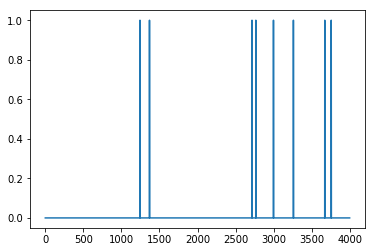

In [9]:
# Binarise the data
X = np.r_[X_src, X_tgt]
binarizer = Binarizer().fit(X)
X_bin = binarizer.transform(X)
plt.plot(X_bin[:,10])

In [10]:
W = np.zeros((X.shape[1], m))
for i in range(m):
    Y_pivot = X_bin[:, sort_idx[-i]]
    model = LogisticRegression(C = 1)
    model.fit(X_bin, Y_pivot)
    W[:, i] = model.coef_

## 3. Low-dimensional feature space

In [11]:
u, s, vh = np.linalg.svd(W, full_matrices=False)

In [14]:
# Visualise low-dimensional space
u1 = u[:,2]
u1_sorted = sorted(range(len(u1)), key=lambda i: u1[i])
u1_pos_subspace = [features[i] for i in u1_sorted[-1:-21:-1]]
u1_neg_subspace = [features[i] for i in u1_sorted[:20]]
print(np.asarray(u1_pos_subspace))
print(np.asarray(u1_neg_subspace))

['great' 'a_great' 'waste' 'money' 'waste_of' 'waste_your' 'your_money'
 "don't_waste" 'a_waste' 'your' 'is_great' 'of_money' 'great_movie' 'poor'
 'terrible' 'your_time' 'great_but' 'great_product' "don't" 'what_a']
['best' 'well' 'the_best' 'i' 'as_well' 'who' 'love' 'excellent' 'was' 'he'
 'his' 'well_as' 'she' 'also' 'ever' 'not' 'well_i' 'worse' 'perfect'
 'wonderful']


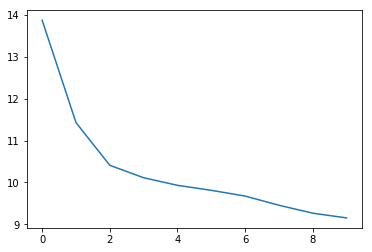

In [18]:
plt.plot(s[:10])

In [19]:
# The low dimensional subspace from the third components show confusing features
l = 50
theta = u[:,:l]
theta.shape

(10000, 50)

## 4. Prediction using enhanced feature space

In [20]:
# Baseline Classifier
model_BL= LogisticRegression(C = 1) # Regularisation parameter C 
model_BL.fit(X_src, Y_src)
print('train {:s} acc: {:.3f}, test {:s} acc: {:.3f}'\
      .format(src, model_BL.score(X_src, Y_src), tgt, model_BL.score(X_tgt,Y_tgt)))

train dvd acc: 1.000, test kitchen acc: 0.774


In [21]:
def tune_reg_param_unsupervised(C_test, X_src_SCL, Y_src, X_tgt, Y_tgt, dev_size):
    X_train, X_dev, Y_train, Y_dev = train_test_split(X_src_SCL, Y_src, test_size = dev_size, random_state = 3)
    acc_train = []
    acc_dev = []
    for C in C_test:
        model_SCL = LogisticRegression(C = C) 
        model_SCL.fit(X_train, Y_train)
        acc_train.append(model_SCL.score(X_train, Y_train))
        acc_dev.append(model_SCL.score(X_dev, Y_dev))
    C_opt = C_test[np.argmax(acc_dev)]
    model_SCL = LogisticRegression(C = C_opt) 
    model_SCL.fit(X_train, Y_train)
    print('optimal alpha', C_opt, 'max acc', max(acc_dev),'test acc', model_SCL.score(X_tgt, Y_tgt))
    plt.plot(C_test, acc_train)
    plt.plot(C_test, acc_dev)

optimal alpha 0.0615789473684 max acc 0.86 test acc 0.801


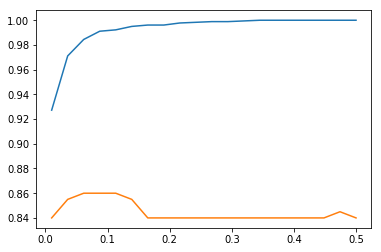

In [22]:
# Enhanced feature space
scale_factor = 1
# scale_factor = X_mean/X_SCL_mean*5
X_src_SCL = np.c_[X_src, scale_factor*np.dot(X_src, theta)]
X_tgt_SCL = np.c_[X_tgt, scale_factor*np.dot(X_tgt, theta)]
C_test = np.linspace(0.01,0.5,20)
tune_reg_param_unsupervised(C_test, X_src_SCL, Y_src, X_tgt_SCL, Y_tgt, 0.1)

## Scaling of enhanced feature in SCL
**The 2006 work scaled the enhanced feature such that their $\ell_1$ norm is 5 times the original features.** 

In [23]:
X_l1 = np.sum(np.abs(X_src))
X_SCL_l1 = np.sum(np.abs(np.dot(X_src, theta)))
print(X_SCL_l1/X_l1)

0.219426322873


In [47]:
scale_factor = X_l1/X_SCL_l1*5
print('scaling factor for 5 times l1 norm in enhanced feature space', scale_factor)

scaling factor for 5 times l1 norm 22.786691836


optimal alpha 0.0621052631579 max acc 0.875 test acc 0.8015


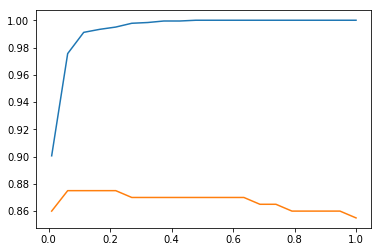

In [25]:
X_src_SCL = np.c_[X_src, scale_factor*np.dot(X_src, theta)]
X_tgt_SCL = np.c_[X_tgt, scale_factor*np.dot(X_tgt, theta)]
C_test = np.linspace(0.01,1,20)
tune_reg_param_unsupervised(C_test, X_src_SCL, Y_src, X_tgt_SCL, Y_tgt, 200)

optimal alpha 0.478947368421 max acc 0.835 test acc 0.7995


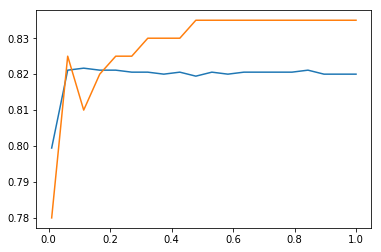

In [26]:
# Try using only the low-dimensional space
X_src_SCL2 = np.dot(X_src, theta)
X_tgt_SCL2 = np.dot(X_tgt, theta)
C_test = np.linspace(0.01,1,20)
tune_reg_param_unsupervised(C_test, X_src_SCL2, Y_src, X_tgt_SCL2, Y_tgt, 200)

In [27]:
# Try out different scale factors
scale_list = [1]+[5*(i+1) for i in range(10)]
scale_acc = []
for i in range(11):
    scale_factor = scale_list[i]
    X_src_SCL = np.c_[X_src, scale_factor*np.dot(X_src, theta)]
    X_tgt_SCL = np.c_[X_tgt, scale_factor*np.dot(X_tgt, theta)]
    model_SCL= LogisticRegression(C = 0.06) # Regularisation parameter C
    model_SCL.fit(X_src_SCL, Y_src)
    scale_acc.append(model_SCL.score(X_tgt_SCL,Y_tgt))

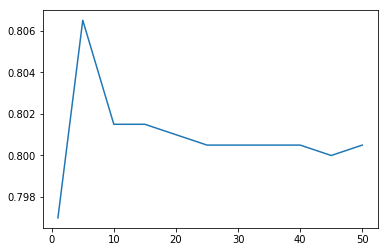

In [28]:
plt.plot(scale_list, scale_acc)

In [29]:
# Weights of the pivot features
u_pivot = u[sort_idx[-m:],:]
u_non_pivot = u[sort_idx[:-m],:]
print('pivot mean/Non pivot mean:  ', np.mean(abs(u_pivot))/np.mean(abs(u_non_pivot)))

pivot mean/Non pivot mean:   15.9192453381


## Finding the subspace of non-pivot feature only
Given the results above, the pivot features have 16 as much weight as the non-pivot ones. Is SCL simply enhancing the pivot features? Would the subspace trained on non-pivot features work too?

In [30]:
# Select non-pivot features
X_bin_non = X_bin[:, sort_idx[:-m]]
X_bin_non.shape

(4000, 9950)

In [31]:
from sklearn.linear_model import LogisticRegression
W_non = np.zeros((X_bin_non.shape[1], m))
for i in range(m):
    Y_pivot = X_bin[:, sort_idx[-i]]
    model = LogisticRegression(C = 1)
    model.fit(X_bin_non, Y_pivot)
    W_non[:, i] = model.coef_

In [32]:
u_non, s, vh = np.linalg.svd(W_non, full_matrices=False)

In [34]:
non_pivot_features = [features[i] for i in sort_idx[:-m]]

In [39]:
u1 = u_non[:,3]
u1_sorted = sorted(range(len(u1)), key=lambda i: u1[i])
u1_pos_subspace = [non_pivot_features[i] for i in u1_sorted[-1:-21:-1]]
u1_neg_subspace = [non_pivot_features[i] for i in u1_sorted[:20]]
print(np.asarray(u1_pos_subspace))
print(np.asarray(u1_neg_subspace))

['is_no' 'with_no' 'are_not' 'does_not' 'and_no' 'one_of' "you_don't"
 'nice' 'even_if' 'two_of' 'to_know' 'wash' 'mother' 'gets' 'you_want'
 "i've" 'buy_this' 'light' 'way_to' 'awkward']
['i_was' 'it_was' 'was_a' 'was_very' 'movie_was' 'this_was' 'and_was'
 'was_the' 'i_have' 'that_was' 'i_love' 'was_not' 'there_was' 'was_so'
 'was_that' 'film_was' 'and_i' 'i_had' 'i_bought' 'i_would']


In [42]:
l = 50
theta = u_non[:,:l]
theta.shape

(9950, 50)

In [45]:
# Train a classifier with enhanced subspace
X_src_SCL_non = np.c_[X_src, np.dot(X_src[:, sort_idx[:-m]], theta)]
X_tgt_SCL_non = np.c_[X_tgt, np.dot(X_tgt[:, sort_idx[:-m]], theta)]

optimal alpha 0.0621052631579 max acc 0.855 test acc 0.795


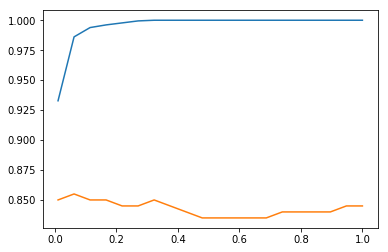

In [46]:
C_test = np.linspace(0.01,1,20)
tune_reg_param_unsupervised(C_test, X_src_SCL_non, Y_src, X_tgt_SCL_non, Y_tgt, 200)